# Line spectra estimation

In [316]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"
%matplotlib inline

import numpy as np
import scipy.signal as sig
from scipy.linalg import toeplitz, eig

# biased autocorrelation (MATLAB: >> xcorr(x, N-1, 'biased') )
def autocorr_b(x):
    n = len(x)
    rxx = 1/n * sig.correlate(x,x, mode='full', method='direct')
    
    return rxx

# plot zeros and poles
def zplane(zeros, poles):
    t = np.linspace(-1,2*np.pi, 100)

    plt.plot(np.cos(t), np.sin(t), '--', color='xkcd:grey')
    plt.plot(np.real(zeros), np.imag(zeros), 'bo', label='zeros', mfc='none')
    plt.plot(np.real(poles), np.imag(poles), 'gx', label='poles')
    plt.grid()

    plt.axis('equal') # makes unit-circle round
    plt.legend(bbox_to_anchor=(1.1, 1.1), loc=2)

## Pisarenko harmonic decomposition

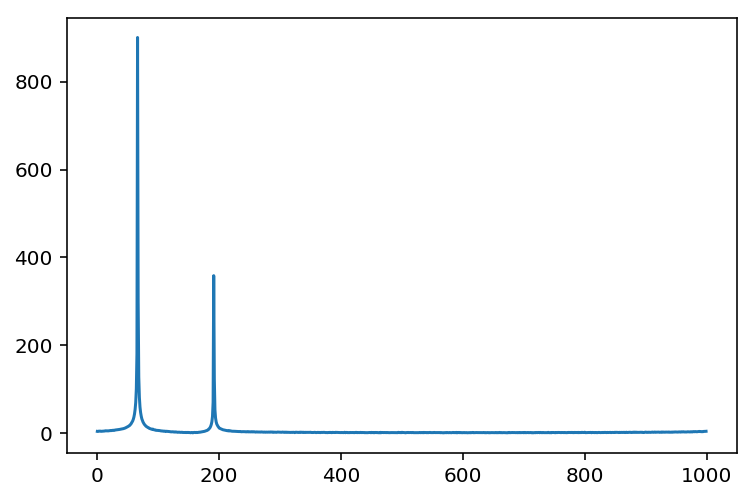

In [421]:
L = 1000     # number of samples
fs = 8000    # sample rate 
t = np.arange(L)/fs
# signal 1
f0 = 530     # Hz
A0 = 1
sig0 = A0*np.exp(1j*2*np.pi*t*f0)

# signal 2
f1 = 1530   # Hz
A1 = 0.4   
sig1 = A1*np.exp(1j*2*np.pi*t*f1)

# noise
sigma = 0.01
noise = np.random.normal(0, sigma, L)

# compose the signal
x = noise + sig0 + sig1

# just to see if all signals are there
plt.plot(abs(np.fft.fft(x)))

# dimension of the auto correlation matrix
N = 3

[[1.16020246+0.j         0.97090325-0.55258925j 0.55356516-0.84435152j]
 [0.97090325+0.55258925j 1.16020246+0.j         0.97090325-0.55258925j]
 [0.55356516+0.84435152j 0.97090325+0.55258925j 1.16020246+0.j        ]]
Eigenvalues:  [3.32336e+00-0.j 1.55810e-01+0.j 1.44000e-03-0.j]
Estimated frequencies: [ 527.84085065 1527.96645692]


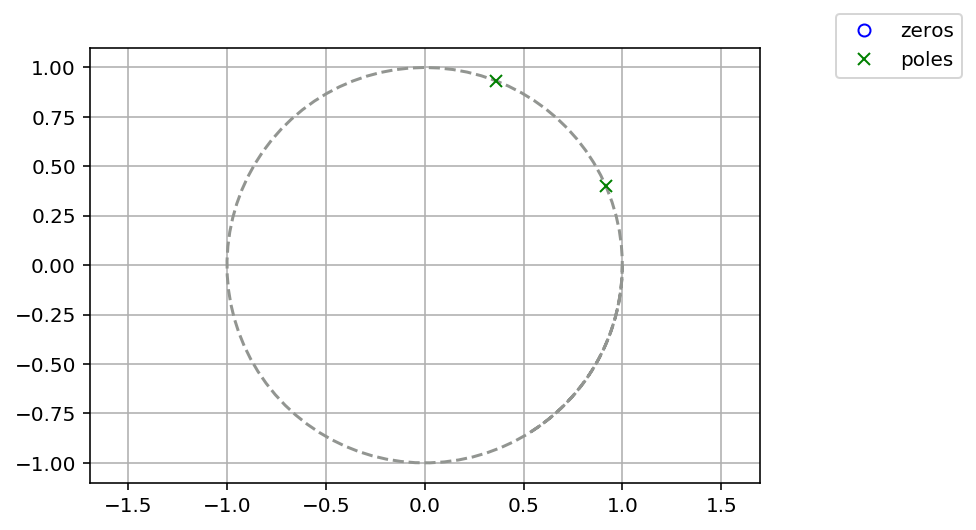

In [422]:
# estimate the biased auto correlation
rxxb = autocorr_b(x)

# we are only interessted in the L-1 to L-N-1 samples of the autocorrelation series
Rxx = toeplitz(rxxb[L-1:L+N-1])
print(np.array2string(Rxx))

# compute eigenvalues and eigenvektors
w, v = eig(Rxx)

print("Eigenvalues: ", np.round(w, 5))

# determine smallest eigenvalue and get its eigenvector
v_min = v[:,np.argmin(w)]
roots = np.roots(v_min)

zplane([], roots)

freq = np.angle(roots)*fs/(2*np.pi)

print("Estimated frequencies:", freq)

# MUSIC

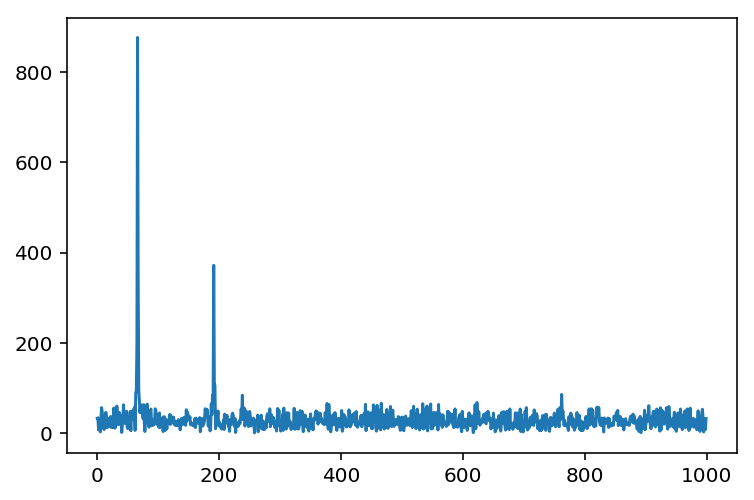

In [423]:
L = 1000     # number of samples
fs = 8000    # sample rate 
t = np.arange(L)/fs
# signal 1
f0 = 530     # Hz
A0 = 1
sig0 = A0*np.exp(1j*2*np.pi*t*f0)

# signal 2
f1 = 1530   # Hz
A1 = 0.4   
sig1 = A1*np.exp(1j*2*np.pi*t*f1)

# noise
sigma = 1
noise = np.random.normal(0, sigma, L)

# compose the signal
x = noise + sig0 + sig1

# just to see if all signals are there
plt.plot(abs(np.fft.fft(x)))

M = 2   # number of harmonics
N = 8   # dimension of the auto-correlation matrix

Eigenvalues:  [8.71934103 2.26746785 0.85360366 0.87171593 0.89866593 0.9806002
 1.01001524 1.00163999]
Noise threshold: 1.622063576574365


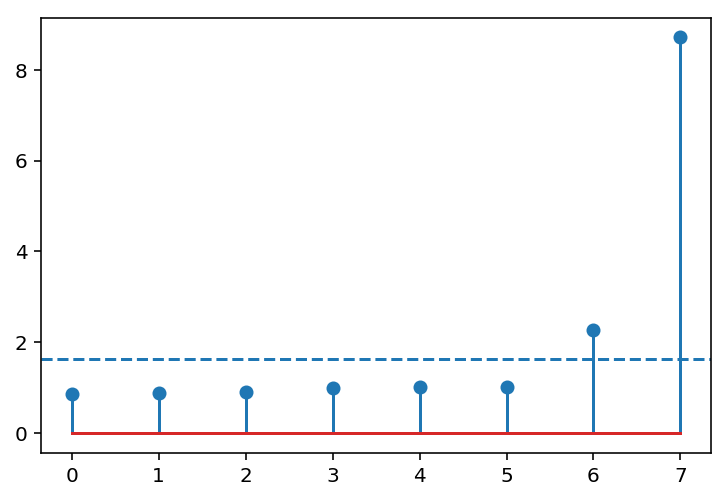

In [424]:
# estimate the biased auto correlation
rxxb = autocorr_b(x)

# we are only interessted in the L-1 to L-N-1 samples of the autocorrelation series
Rxx = toeplitz(rxxb[L-1:L+N-1])
#print(np.array2string(Rxx))

# compute eigenvalues and eigenvektors
w, v = eig(Rxx)

print("Eigenvalues: ", np.real(w))

# compute noise threshold
w_sorted = np.real(np.sort(w))
thresh = 1.8 * np.real(np.mean(w_sorted[0:4]))

print("Noise threshold:", thresh)
plt.stem(w_sorted)
l = plt.axhline(y=thresh, linestyle='--')

Estimated frequencies: [-1605.99524134  -467.44991809   529.72171001  1537.47836862
 -3444.05213593  3150.15420232  3739.26686142]


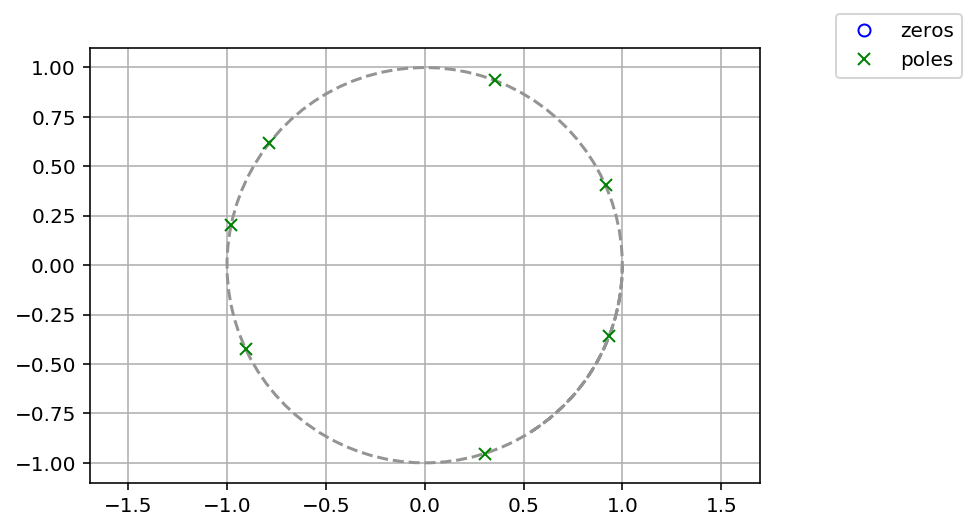

In [426]:
# we pick one of the noise vectors
w_noise_idx = np.where(np.real(w) <= thresh)[0]
freq_idx = np.where(np.real(w) > thresh)[0]
v_noise = v[:,w_noise_idx[0]]

roots = np.roots(v_noise)

zplane([], roots)

freq = np.angle(roots)*fs/(2*np.pi)

print("Estimated frequencies:", freq)

## Verify auto-correlation series

In [418]:
x = np.array([-0.64+1.06j, -0.86+0.45j, -0.67+0.12j, -0.60+0.14j])
N = 4

In [420]:
rxxb = autocorr_b(x)
Rxx = toeplitz(rxxb[N-1:L+2*N-2])
print("Auto-correlation matrix:", np.array2string(Rxx))
w, v = eig(Rxx)
print("Eigenvector:", np.array2string(v))
print("Eigenvalue: ", np.array2string(w))

Auto-correlation matrix: [[0.82955+0.j       0.5191 -0.200025j 0.28375-0.19575j  0.1331 -0.1366j  ]
 [0.5191 +0.200025j 0.82955+0.j       0.5191 -0.200025j 0.28375-0.19575j ]
 [0.28375+0.19575j  0.5191 +0.200025j 0.82955+0.j       0.5191 -0.200025j]
 [0.1331 +0.1366j   0.28375+0.19575j  0.5191 +0.200025j 0.82955+0.j      ]]
Eigenvector: [[ 0.36237461-0.2622826j   0.64057627+0.j          0.04207547-0.5435465j
  -0.24645706+0.17776476j]
 [ 0.52111042-0.16833425j  0.25053456+0.16399537j -0.15637747+0.42229486j
   0.63848149+0.j        ]
 [ 0.5476244 +0.j         -0.25466776-0.15750041j -0.43310422+0.12331906j
  -0.49421185-0.40424405j]
 [ 0.42545278+0.13819351j -0.27129734-0.58028933j  0.54517258+0.j
   0.07821943+0.29363773j]]
Eigenvalue:  [2.12028829+1.81884755e-17j 0.74273096+1.56140457e-17j
 0.28535731+3.68442826e-17j 0.16982343+1.26199230e-17j]
